In [1]:
import gc
import numpy as np
import pandas as pd
import xarray as xr
import metpy.constants as mpconsts

from glob import glob
from os.path import isfile
from functools import reduce
from datetime import datetime, timedelta

from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde, skew

import matplotlib.pyplot as plt

## Define paths and acquire list of available data

In [22]:
obdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'
profdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/era5/profiles/'

## Build into a loop over all stations

In [23]:
flist = glob(obdir + 'clean/*.pd')

# This can be a manual site list if desired
site_list = [f.split('/')[-1].split('_')[0] for f in flist]
site_list

['PVC',
 'CLNX',
 'BCC',
 'AGD',
 'ALTA',
 'BSNFDC',
 'BSNFEX',
 'BSNFJE',
 'SLB',
 'CSSL']

In [52]:
# for site in site_list:
site = 'CSSL'

### Obtain the metadata

In [54]:
meta_file = glob(obdir + '*Metadata*.xlsx')[0]

metadata = pd.read_excel(meta_file)

# Temp fix to use CLNX instead of CLN data
metadata['code'] = metadata['code'].replace('CLN', 'CLNX')
metadata = metadata.set_index('code').loc[site]

# Determine the lat, lon of the site from the metadata
site_lat, site_lon = metadata['lat'], metadata['lon']
site_elev = metadata['elevation_m']

metadata

Unnamed: 0                                                    10
name                                     Central Sierra Snow Lab
owner                          University of California Berkeley
city                                                 Donner Pass
state                                                         CA
lat                                                      39.3255
lon                                                     -120.368
elevation_m                                                 2103
start                                                        NaN
end                                                         2019
interval                                                      24
n_events                                                     NaN
auto_manual                                               Manual
snow_type                                                    NaN
swe_type                                                     NaN
notes          Problemati

### Import the ERA5 Profile

In [26]:
# Import the era5_orog file to check the lat/lon grid
era_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/era5/'
era5_orog_file = era_dir + 'era5_orog.nc'
era5_orog = xr.open_dataset(era5_orog_file)['z'].isel(time=0)
era5_orog = era5_orog.rename({'latitude':'lat', 'longitude':'lon'})
era5_lat, era5_lon = era5_orog['lat'], era5_orog['lon']

# Find the index of the correct lat lon
idx1d = (np.abs(era5_lon - site_lon) + np.abs(era5_lat - site_lat))
idx = np.unravel_index(np.argmin(idx1d.values), idx1d.shape)

# Subset and convert gpm to m
era5_g = 9.80665
era5_orog = era5_orog.isel(lat=idx[1], lon=idx[0])/era5_g

era5_lat, era5_lon = era5_orog['lat'].values, era5_orog['lon'].values
era5_elev = era5_orog.values

print('ERA5 Profile:\n%.2f %.2f %.2f\n'%(era5_lat, era5_lon, era5_elev))

era5_prof_file = 'era5prof_{:.2f}N_{:.2f}W.nc'.format(
    era5_orog['lat'].values, abs(era5_orog['lon'].values))

if isfile(era_dir + 'profiles/' + era5_prof_file):
    era5_prof = xr.open_dataset(era_dir + 'profiles/' + era5_prof_file).load()
    era5_prof = era5_prof.dropna(dim='time')
    print(era5_prof)
    
else:
    print('ERA5 Profile Missing:\n%s'%era5_prof_file)

ERA5 Profile:
39.25 -120.25 2056.19

<xarray.Dataset>
Dimensions:  (level: 23, time: 354288)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2020-06-30T23:00:00
  * level    (level) float64 200.0 225.0 250.0 300.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    Q        (time, level) float32 6.5453305e-06 1.6195607e-05 ... 0.004264637
    T        (time, level) float32 216.47935 215.51334 ... 300.3839 301.75568
    U        (time, level) float32 28.346375 30.428589 ... 2.8500519 2.89888
    V        (time, level) float32 6.10524 9.115982 ... 0.55418396 0.50917053
    VO       (time, level) float32 1.9049505e-05 ... -7.4289273e-06
    W        (time, level) float32 -0.10288429 0.089580536 ... -0.08534336
    Z        (time, level) float32 115642.81 108338.25 ... 3207.6287 1098.9031
    R        (time, level) float32 12.488934 39.772087 ... 26.895897 26.969543
    U100M    (time) float32 4.133194 4.5840607 4.82106 ... 5.550293 5.1300964
    V100M    (time) float32 5.290802

### Import the surface observations

                      maxT  swe24_mm  snow24_mm      slr24
time                                                      
1971-11-25 08:00:00  0.000    62.230       0.00   0.000000
1971-11-26 08:00:00 -1.665    51.308       0.00   0.000000
1971-11-30 08:00:00 -2.775   109.220      93.98   8.604651
1971-12-02 08:00:00 -5.550    46.990      76.20  16.216216
1971-12-16 08:00:00 -4.995    53.848      43.18   8.018868
...                    ...       ...        ...        ...
2019-02-04 08:00:00 -4.000    71.000      52.50   7.394366
2019-02-09 08:00:00 -5.000    75.000      11.00   1.466667
2019-02-15 08:00:00 -5.000    28.000      23.00   8.214286
2019-02-17 08:00:00 -1.000    28.000      32.00  11.428571
2019-02-26 08:00:00 -1.000   101.000      79.00   7.821782

[426 rows x 4 columns]


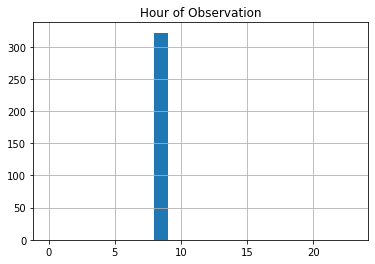

In [37]:
try:
    obs = pd.read_pickle(glob(obdir + 'clean/%s*.pd'%site)[0]).reset_index().rename(
        columns={'index':'time'}).set_index('time')
except:
    obs = pd.read_pickle(glob(obdir + 'clean/%s*.pd'%site)[0]).reset_index().rename(
        columns={'datetime_utc':'time'}).set_index('time')

print(obs)

obs = obs[obs.index > datetime(1980, 8, 1)]
obs = obs.dropna(how='all')

plt.figure(facecolor='w')
plt.hist([t.hour for t in obs.index], bins=np.arange(0, 24, 1))
plt.grid()
plt.title('Hour of Observation')
plt.show()

obs[:10]

intervals = [int(k.replace('slr', '')) for k in obs if 'slr' in k]

### Prune observations based on minimum qpf, snow, and max T 

In [42]:
try:
    obs = obs[((obs['swe12_mm'] > 1.4) & (obs['snow12_mm'] >= 25.5))]
except:
    print('24h Data Used to Constrain SWE/SNOW')
    obs = obs[((obs['swe24_mm'] > 2.8) & (obs['snow24_mm'] >= 51.0))]
else:
    print('12h Data Used to Constrain SWE/SNOW')

print(obs.shape)

try:
    obs = obs.drop_duplicates()
except:
    pass
else:
    print(obs.shape)

# obs = obs.iloc[np.where(np.array([len(pp) for pp in obs['precip_periods']]) > 0)[0]]
print(obs.shape)

obs

24h Data Used to Constrain SWE/SNOW
(81, 4)
(81, 4)
(81, 4)


,maxT,swe24_mm,snow24_mm,slr24
time,,,,
1980-12-24 08:00:00,-2.220,73.914,83.82,11.340206
1980-12-25 08:00:00,-3.330,26.670,60.96,22.857143
1981-01-27 08:00:00,0.000,99.822,71.12,7.124682
1982-01-04 08:00:00,-2.220,95.250,87.63,9.200000
1982-03-02 08:00:00,-2.775,43.180,59.69,13.823529
...,...,...,...,...
2017-02-20 08:00:00,0.000,111.000,62.00,5.585586
2018-03-03 08:00:00,-2.000,26.000,59.00,22.692308
2018-03-16 08:00:00,-4.000,73.000,64.00,8.767123


### Investigate the data with a few plots

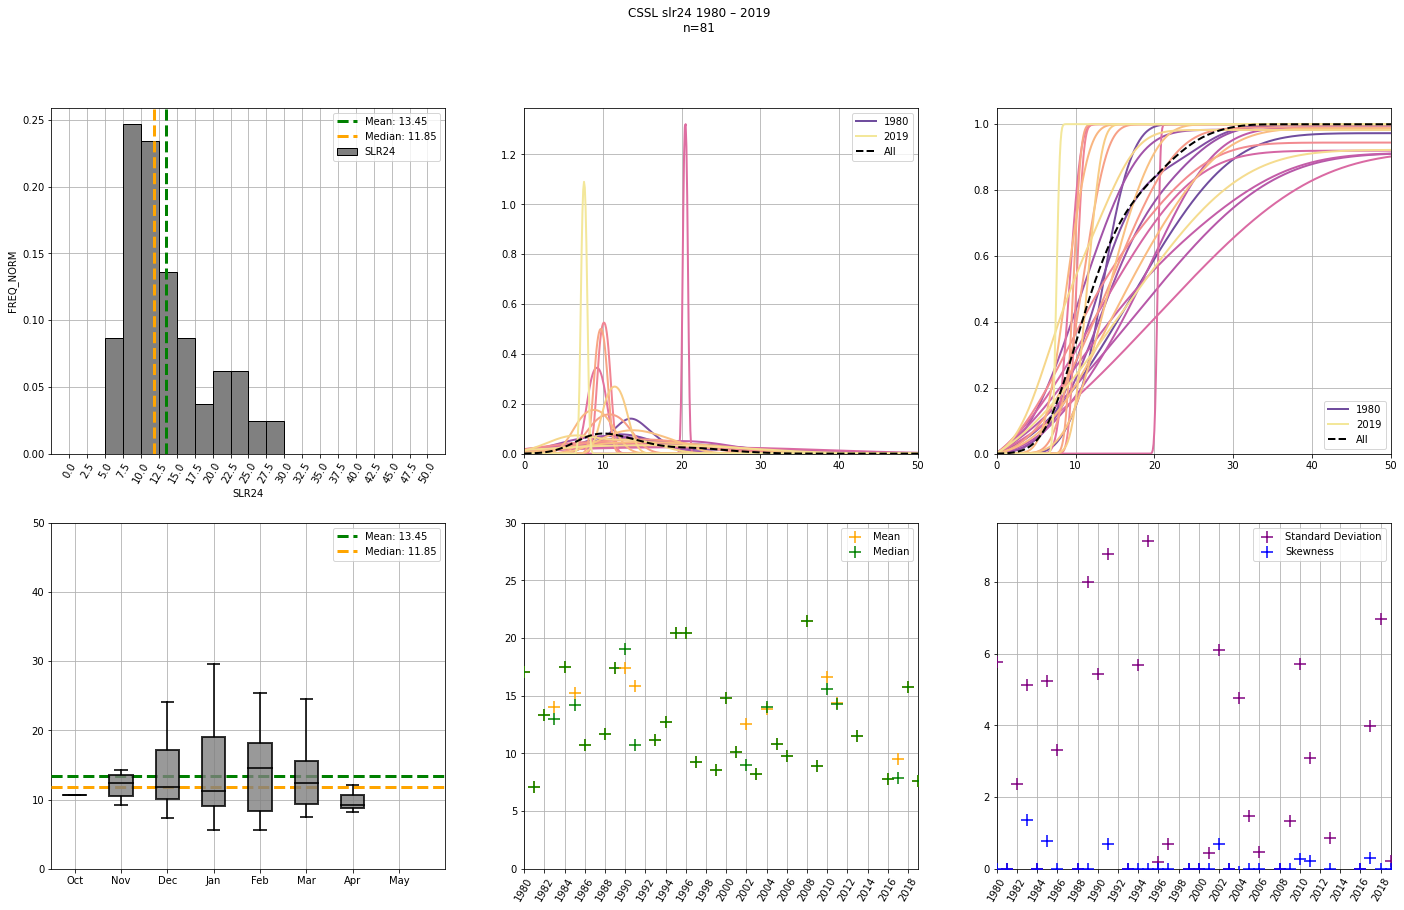

In [46]:
ycolors = ("#704D9E","#704D9E","#7A4EA0","#824EA3","#8B4FA4","#9350A6","#9B51A7","#A253A8","#AA54A9",
           "#B156A9","#B758A9","#BE5AA9","#C45DA8","#CA60A7","#CF63A6","#D566A4","#DA6AA3","#DE6DA1",
           "#E3719E","#E7759C","#EB7A99","#EE7F96","#F18493","#F28A90","#F48F8D","#F5958B","#F79A88",
           "#F7A086", "#F8A684","#F9AB83","#F9B182","#F9B681","#F9BC81","#F9C182","#F8C783","#F8CC85",
           "#F7D288","#F6D78B","#F5DC8F","#F4E294","#F3E79A")

binwidth = 2.5

for k in [k for k in obs if 'slr' in k]:

    fig, axs = plt.subplots(2, 3, figsize=(24, 14), facecolor='w')
    axs = axs.flatten()
    ax1, ax2, ax3, ax4, ax5, ax6 = axs
    
    histargs = {'width':1, 'color':'0.5', 'edgecolor':'k', 'zorder':10}
    vlineargs = {'linewidth':3, 'linestyle':'--', 'zorder':11}
    xyargs = {'s':150, 'marker':'+', 'linewidth':1.5, 'zorder':10}
    
    v1, b1 = np.histogram(obs[k].values, bins=np.arange(0, 50+1, binwidth))    
    ax1.bar(np.arange(.5, len(v1), 1), v1/sum(v1), label=k.upper(), **histargs)
    vmean = obs[k].mean()
    ax1.axvline(vmean/binwidth, c='green', label='Mean: %.2f'%vmean, **vlineargs)
    vmed = obs[k].median()
    ax1.axvline(vmed/binwidth, c='orange', label='Median: %.2f'%vmed, **vlineargs)
    
    ax1.set_xticks(np.arange(len(b1)))
    ax1.set_xticklabels(b1, rotation=60)
    ax1.set_xlabel(k.upper())
    ax1.set_ylabel('FREQ_NORM')
    
    years = np.unique([t.year for t in obs.index])
    nyears = len(years)
    ygrays = np.linspace(.8, .4, nyears).astype(str)
    
    colid = np.linspace(0, len(ycolors)-1, nyears, dtype=int)
    
    for i, year in enumerate(np.unique([t.year for t in obs.index])):
        
        label = year if i==0 or i==nyears-1 else None
        yobs = obs[k].iloc[[i for i, t in enumerate(obs.index) if t.year == year]]

        try:
            n, x = np.histogram(yobs.dropna(), bins=np.arange(0, 50+1, 0.1))
            ax2.plot(x, gaussian_kde(yobs.dropna())(x), color=ycolors[colid[i]], linewidth=2, label=label)

            n, x = np.histogram(yobs.dropna(), bins=np.arange(0, 50+1, 0.1))
            ax3.plot(x, np.cumsum(gaussian_kde(yobs.dropna())(x))/10, color=ycolors[colid[i]], linewidth=2, label=label)
        except:
            pass
            #raise
        
        ax5.scatter(year, yobs.dropna().mean(), c='orange', **xyargs)
        ax5.scatter(year, yobs.dropna().median(), c='green', **xyargs)        
        ax6.scatter(year, np.std(yobs.dropna()), c='purple', **xyargs)
        ax6.scatter(year, skew(yobs.dropna()), c='blue', **xyargs)
        
    ax5.scatter(year, -1, c='orange', label='Mean', **xyargs)
    ax5.scatter(year, -1, c='green', label='Median', **xyargs)        
    ax6.scatter(year, -1, c='purple', label='Standard Deviation', **xyargs)
    ax6.scatter(year, -1, c='blue', label='Skewness', **xyargs)

    
    n, x = np.histogram(yobs, bins=np.arange(0, 50+1, 0.1))
    ax2.plot(x, gaussian_kde(obs[k].dropna())(x), 'k--', linewidth=2, label='All')
    n, x = np.histogram(yobs, bins=np.arange(0, 50+1, 0.1))
    ax3.plot(x, np.cumsum(gaussian_kde(obs[k].dropna())(x))/10, 'k--', linewidth=2, label='All')
    
    mobs = []
    for i, month in enumerate([10, 11, 12, 1, 2, 3, 4, 5]):
        _mobs = obs[k].iloc[[i for i, t in enumerate(obs.index) if t.month == month]]
        _mobs = _mobs[~np.isnan(_mobs)]
        mobs.append(_mobs)
        
    bp = ax4.boxplot(mobs, showfliers=False, patch_artist=True, zorder=15)
    [[box.set(linewidth=2, color='k', alpha=0.8) for box in bp[k]] 
         for k in ['boxes', 'whiskers', 'medians', 'means', 'caps']]
    [patch.set_facecolor('0.5') for patch in bp['boxes']]
    
    ax4.axhline(vmean, c='green', label='Mean: %.2f'%vmean, **vlineargs)
    ax4.axhline(vmed, c='orange', label='Median: %.2f'%vmed, **vlineargs)
    
    ax4.set_xlim(right=9)
    ax4.set_ylim([0, 50])
    ax4.set_xticklabels(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May'])
    
    ax5.set_ylim(top=30)
    for ax in [ax5, ax6]:
        ax.set_xlim([years[0], years[-1]])
        ax.set_xticks(np.arange(years[0], years[-1], 1)[::2])
        ax.set_xticklabels(np.arange(years[0], years[-1], 1)[::2], rotation=60)
    
    for ax in [ax2, ax3]:
        ax.set_xlim(right=50)
        ax.set_xlim(left=0)
    
    for ax in axs:
        ax.set_ylim(bottom=0)
        ax.legend()
        ax.grid()
    
    plt.suptitle('%s %s %d – %d\nn=%d'%(site, k, years[0], years[-1], obs[k].dropna().index.size))
    # plt.tight_layout()
    plt.show()
    plt.close()

## Match ERA and GFS levels

In [47]:
# Noting that the GFS has less vertical levels than the ERA5, 
# trim here if we are going to use index vs matched levels
gfs_levels = [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 
              700, 750, 800, 850, 900, 925, 950, 975, 1000]

era5_prof = era5_prof.sel(level=gfs_levels)

era5_prof

<xarray.Dataset>
Dimensions:  (level: 19, time: 354288)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2020-06-30T23:00:00
  * level    (level) float64 200.0 250.0 300.0 350.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    Q        (time, level) float32 6.5453305e-06 3.70547e-05 ... 0.004264637
    T        (time, level) float32 216.47935 216.493 ... 300.3839 301.75568
    U        (time, level) float32 28.346375 34.175156 ... 2.8500519 2.89888
    V        (time, level) float32 6.10524 9.003067 ... 0.55418396 0.50917053
    VO       (time, level) float32 1.9049505e-05 ... -7.4289273e-06
    W        (time, level) float32 -0.10288429 0.3276558 ... -0.08534336
    Z        (time, level) float32 115642.81 101816.0 ... 3207.6287 1098.9031
    R        (time, level) float32 12.488934 88.03079 ... 26.895897 26.969543
    U100M    (time) float32 4.133194 4.5840607 4.82106 ... 5.550293 5.1300964
    V100M    (time) float32 5.290802 5.03891 4.5393524 ... 1.0753784 0.9711151
    U10M     (time) float32 2.2147827 2.3719635 2.629303 ... 3.9078217 3.6135712
    V10M     (time) float32 2.7101288 2.5075073 ... 0.7776489 0.7270355
    D2M      (time) float32 275.0534 274.50974 275.3457 ... 273.72888 273.87195
    T2M      (time) float32 275.1148 275.77832 275.41733 ... 293.2611 293.00223
    BLH      (time) float32 679.8231 621.6776 613.5834 ... 1743.9008 1739.7386
    CAPE     (time) float32 52.5 66.0 51.375 55.625 68.875 ... 0.0 0.0 0.0 0.0
    MSL      (time) float32 101975.19 101971.25 ... 101395.81 101328.31
    SP       (time) float32 79425.016 79412.84 79440.45 ... 79567.2 79526.81

### Take care of the derived variables
Wind Speed, Wind Direction<br>


In [48]:
for level_set in ['', '10M', '100M']:
    
    u = era5_prof['U%s'%level_set] 
    v = era5_prof['V%s'%level_set]
    
    wspd = np.sqrt((u**2) + (v**2))
    wdir = 90 - np.degrees(np.arctan2(-v, -u))
    wdir = xr.where(wdir <= 0, wdir+360, wdir)
    wdir = xr.where(((u == 0) & (v == 0)), 0, wdir)
    
    era5_prof['SPD%s'%level_set] = wspd.astype(np.float32)
    era5_prof['DIR%s'%level_set] = wdir.astype(np.float32)

In [49]:
era5_prof

<xarray.Dataset>
Dimensions:  (level: 19, time: 354288)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2020-06-30T23:00:00
  * level    (level) float64 200.0 250.0 300.0 350.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    Q        (time, level) float32 6.5453305e-06 3.70547e-05 ... 0.004264637
    T        (time, level) float32 216.47935 216.493 ... 300.3839 301.75568
    U        (time, level) float32 28.346375 34.175156 ... 2.8500519 2.89888
    V        (time, level) float32 6.10524 9.003067 ... 0.55418396 0.50917053
    VO       (time, level) float32 1.9049505e-05 ... -7.4289273e-06
    W        (time, level) float32 -0.10288429 0.3276558 ... -0.08534336
    Z        (time, level) float32 115642.81 101816.0 ... 3207.6287 1098.9031
    R        (time, level) float32 12.488934 88.03079 ... 26.895897 26.969543
    U100M    (time) float32 4.133194 4.5840607 4.82106 ... 5.550293 5.1300964
    V100M    (time) float32 5.290802 5.03891 4.5393524 ... 1.0753784 0.9711151
    U10M     (time) float32 2.2147827 2.3719635 2.629303 ... 3.9078217 3.6135712
    V10M     (time) float32 2.7101288 2.5075073 ... 0.7776489 0.7270355
    D2M      (time) float32 275.0534 274.50974 275.3457 ... 273.72888 273.87195
    T2M      (time) float32 275.1148 275.77832 275.41733 ... 293.2611 293.00223
    BLH      (time) float32 679.8231 621.6776 613.5834 ... 1743.9008 1739.7386
    CAPE     (time) float32 52.5 66.0 51.375 55.625 68.875 ... 0.0 0.0 0.0 0.0
    MSL      (time) float32 101975.19 101971.25 ... 101395.81 101328.31
    SP       (time) float32 79425.016 79412.84 79440.45 ... 79567.2 79526.81
    SPD      (time, level) float32 28.996395 35.341145 ... 2.903432 2.9432566
    DIR      (time, level) float32 257.8453 255.24136 ... 258.99634 260.03796
    SPD10M   (time) float32 3.5000088 3.4516377 3.51646 ... 3.9844458 3.685984
    DIR10M   (time) float32 219.25652 223.40881 228.39265 ... 258.74527 258.6242
    SPD100M  (time) float32 6.713857 6.812065 6.621808 ... 5.6535115 5.2212024
    DIR100M  (time) float32 217.99709 222.29381 226.72382 ... 259.0347 259.28088

### Resample to observation interval
From 1h or 3h ERA5 to 6, 12, 24h observations<br>
I think we need to manually resample here...<br>
to account for irregular observation intervals at some stations

In [50]:
resample_these = {
    'max':['Q', 'T', 'U', 'V', 'VO', 'W', 'Z', 'R', 'T2M', 'D2M', 'BLH', 'CAPE', 'MSL',
           'SP', 'SPD', 'DIR', 'U10M', 'V10M', 'U100M', 'V100M', 'SPD10M', 'DIR10M', 'SPD100M', 'DIR100M'],
    
    'min':['Q', 'T', 'VO', 'Z', 'R', 'T2M', 'D2M', 'MSL', 'SP'],
    
    'mean':['Q', 'T', 'U', 'V', 'VO', 'W', 'Z', 'R', 'T2M', 'D2M', 'BLH', 'CAPE', 'MSL', 
           'SP', 'SPD', 'DIR', 'U10M', 'V10M', 'U100M', 'V100M', 'SPD10M', 'DIR10M', 'SPD100M', 'DIR100M']}

In [51]:
for interval in intervals:
    
    left_inclusive = True
    right_inclusive = True

    era5_resampled = []

    for i, t in enumerate(obs.index):

        # Determine start, end
        ti = t - timedelta(hours=interval)    
        ti = ti if left_inclusive else ti + timedelta(hours=1)
        tf = t if right_inclusive else t - timedelta(hours=1)    
        
        try:
            era5_slice = era5_prof.sel(time=obs.loc[t]['precip_periods'])
        except:
            era5_slice = era5_prof.sel(time=slice(ti, tf))
        
        #print(i, t, ti, tf, era5_slice.time.size)
        
        if era5_slice.time.size > 0:

            print('\rresampling %dh %d/%d (slice size %d)'%(interval, i+1, len(obs.index), era5_slice.time.size), end='\r')

            slice_max = era5_slice[resample_these['max']].max(dim='time')
            slice_min = era5_slice[resample_these['min']].min(dim='time')
            slice_mean = era5_slice[resample_these['mean']].mean(dim='time')

            slice_all = []
            for oper in ['max', 'min', 'mean']:
                slice_oper = vars()['slice_%s'%oper]

                for k in slice_oper.keys():
                    slice_oper = slice_oper.rename({k:'%s_%s'%(k, oper)})

                    # Ensure that we label the observation time appropriately
                    slice_oper['time'] = t

                slice_all.append(slice_oper)
            era5_resampled.append(xr.merge(slice_all))
            
    try:
        era5_resampled = xr.concat(era5_resampled, dim='time').dropna(dim='time')
    except:
        raise
        print('Interval %s Failed'%interval)
    else:
        ### Transform 2D vars (level, time) to 1D vars (time) for model input
        isokeys = [k for k in era5_resampled if len(era5_resampled[k].shape) > 1]
        sfckeys = [k for k in era5_resampled if len(era5_resampled[k].shape) == 1]
        
    era5_df = []

    for l in era5_resampled.level.values:

        level_data = era5_resampled[isokeys].sel(level=l).drop('level')#.to_dataframe()
        level_data = level_data.rename({k:'%s%s_%s'%(k.split('_')[0], '_%d'%l, k.split('_')[-1]) for k in level_data.keys()})

        era5_df.append(level_data)

    era5_df = xr.merge(era5_df)
    era5_df
    
    era5_df = xr.merge([era5_df, era5_resampled[sfckeys]])

    era5_df = era5_df.to_dataframe()
    era5_df = era5_df.drop_duplicates().dropna().sort_index()
    era5_df
    
    droplist = [k for k in obs.keys() if (('slr%d'%interval not in k)&('swe%d'%interval not in k))]

    df_merged = obs.drop(columns=droplist).rename(columns={k:k.replace('%d'%interval, '') 
                    for k in obs.drop(columns=droplist).keys()})

    df_merged = df_merged.merge(era5_df, on='time', copy=False)
    df_merged
    
    df_merged = df_merged.dropna().drop_duplicates()
    df_merged = df_merged.loc[np.in1d(df_merged.index, obs.index)]

    #print(interval, df_merged.shape)
    df_merged.iloc[:10, :12]

    # df_save[interval] = df_merged.copy()
    start, end = df_merged.index[0].year, df_merged.index[-1].year
    df_savestr = obdir + 'combined/' + '%s_%04d_%04d.%02dh.isobaric.pd'%(site, start, end, interval)
    df_merged.to_pickle(df_savestr)
    print('Saved:\n%s'%df_savestr)
    #del df_merged
    #gc.collect()

Saved:ling 24h 81/81 (slice size 25)
/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/combined/CSSL_1980_2019.24h.isobaric.pd
